In [5]:
from quspin.operators import hamiltonian, quantum_operator # Hamiltonians and operators
from quspin.basis import spin_basis_1d, spin_basis_general # Hilbert space spin basis
from quspin.tools.measurements import diag_ensemble
import numpy as np # generic math functions
import matplotlib.pyplot as plt
%matplotlib inline

from quspin.tools.measurements import ED_state_vs_time

import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 30,
})

from scipy.integrate import simps
import itertools

from scipy.optimize import minimize_scalar, shgo


In [2]:
def EC3_hamiltonian(basis,M):
    X = 3
    N = basis.N
    
    J_zz, J_z, offset = [], [], []
    for l in range(M):
        triple = np.random.choice(np.arange(N),size=X,replace=False)
        for m in itertools.product(triple,triple):
            J_zz += [[1,m[0],m[1]]]
        for m in range(X):
            J_z += [[-2,triple[m]]]
        offset += [[1,l]]
    
    return hamiltonian([["zz",J_zz],["z",J_z],["I",offset]],[],basis=basis,dtype=np.float64,check_symm=False,check_herm=False)



In [3]:
def check_USA(H1):
    Es = np.sort(H1.toarray().diagonal())
    if int(Es[0]) == 0 and Es[1] > 0:
        return True
    else:
        return False
    

In [10]:
def USA_hamiltonian(basis):
    is_USA = False
    while not is_USA:
        H = EC3_hamiltonian(basis,M=basis.N-1)
        is_USA = check_USA(H)
    return H

In [11]:
def gap(basis,H1,h):
    N = basis.N
    #quench hamiltonian
    x_field=[[-h,i] for i in range(N)]
    static=[H1.static,["x",x_field]]
    H2 =  hamiltonian(static,[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)
    E2,V2=H2.eigh()
    
    return (E2[1]-E2[0])/(E2[-1]-E2[0])

In [12]:
def gap_sparse(basis,H1,h):
    N = basis.N
    #quench hamiltonian
    x_field=[[-h,i] for i in range(N)]
    static=[H1.static,["x",x_field]]
    H2 =  hamiltonian(static,[],basis=basis,dtype=np.float64,check_symm=False, check_herm=False)
    E2=H2.eigsh(k=2,which='SA',return_eigenvectors=False)[::-1]
    E3=H2.eigsh(k=1,which='LA',return_eigenvectors=False)[0]
    
    return (E2[1]-E2[0])/(E3-E2[0])

In [28]:
def minimalGap(N_spins,N_instance):
    basis = spin_basis_general(N_spins)
    
    h_c_Deltas = np.zeros(N_instance)
    Hamiltonians = np.zeros((N_instance,2**N_spins))
    hs = np.linspace(0,4,100)
    for i in range(N_instance):
        print(i, end='\r')
        H = USA_hamiltonian(basis)
        Hamiltonians[i] = H.toarray().diagonal()
        
        try:
            f_Delta = lambda x: gap_sparse(basis,H,x)
            Gs = np.zeros(len(hs))
            for j,h in enumerate(hs):
                Gs[j] = f_Delta(h)
            temp = np.argmin(Gs)
            h_c_Deltas[i] = minimize_scalar(f_Delta,bounds=(hs[temp-1],hs[temp+1]),method='bounded').x
        except:
            f_Delta = lambda x: gap(basis,H,x)
            Gs = np.zeros(len(hs))
            for j,h in enumerate(hs):
                Gs[j] = f_Delta(h)
            temp = np.argmin(Gs)
            h_c_Deltas[i] = minimize_scalar(f_Delta,bounds=(hs[temp-1],hs[temp+1]),method='bounded').x


    np.save('ML_h_c_Deltas_sparse_N{}'.format(N_spins),h_c_Deltas)
    np.save('ML_Hamiltonians_sparse_N{}'.format(N_spins),Hamiltonians)
    

In [3]:
Ns = np.arange(5,11)

In [ ]:
for N in Ns:
    print('N_spins: ',N)
    minimalGap(N,10000)

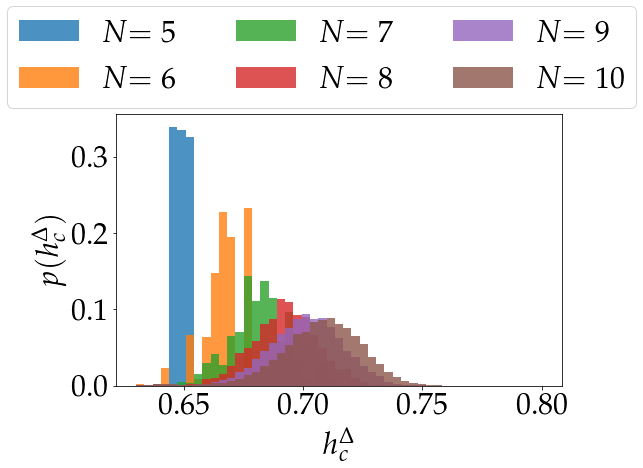

In [17]:
plt.figure(figsize = (8, 5))
for N in Ns:
    try:
        h_s = np.load('ML_h_c_Deltas_sampleLocal_N{}.npy'.format(N))
    except:
        h_s = np.load('ML_h_c_Deltas_sparse_N{}.npy'.format(N))
    plt.hist(1/(1+1/h_s),label=r'$N$'+'$={}$'.format(N),alpha=.8,bins=np.linspace(.63,.8),weights=1e-4*np.ones(10000));

plt.legend(bbox_to_anchor=(1.2, 1.45),ncol=3)
#plt.legend(loc=1,ncol=1)
plt.xlabel(r'$h_c^\Delta$')
plt.ylabel(r'$p(h_c^\Delta)$')
#plt.title('sample $10^4$ random instances')
plt.savefig('figures/gaps.png',dpi=300,bbox_inches='tight')

In [14]:

mins = np.zeros(len(Ns))
maxs = np.zeros(len(Ns))
avgs = np.zeros(len(Ns))
for i,N in enumerate(Ns):
    data = np.load('ML_h_c_Deltas_sampleLocal_N{}.npy'.format(N))
    mins[i] = np.min(data)
    maxs[i] = np.max(data)
    avgs[i] = np.average(data)


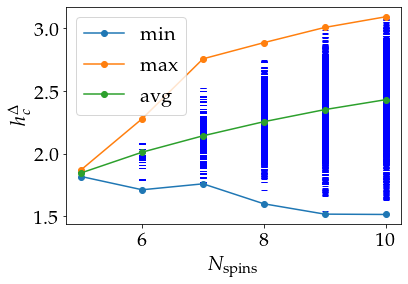

In [22]:
for i,N in enumerate(Ns):
    data = np.load('ML_h_c_Deltas_sampleLocal_N{}.npy'.format(N))
    plt.plot(N*np.ones(10000),data,'b_')
plt.plot(Ns,mins,'o-',label='min')
plt.plot(Ns,maxs,'o-',label='max')
plt.plot(Ns,avgs,'o-',label='avg')
plt.xlabel(r'$N_{\mathrm{spins}}$')
plt.ylabel(r'$h_c^\Delta$')
plt.legend()
plt.savefig('sampleLocal_gaps',dpi=300)